## Stage 0: Setup
• Mục đích: Khởi tạo môi trường PyTorch và các hàm tiện ích quaternion.
• Input: Không.
• Output: Hàm quat_normalize, quat_to_rotmat, biến device.
• Liên hệ 3DGS: 3DGS tham số hóa hiệp phương sai bằng quay R và tỉ lệ S. Quaternion giúp suy ra ma trận quay R ổn định số.


In [1]:
# Stage 0: Setup & Utils
# Nếu cần: !pip install torch torchvision torchaudio imageio

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# ========== Quaternion utils ==========
def quat_normalize(q):
	# q: (..., 4)
	return q / (q.norm(dim=-1, keepdim=True) + 1e-8)

def quat_to_rotmat(q):
	# q = (w, x, y, z)
	w, x, y, z = q.unbind(-1)
	norm = torch.clamp(w*w + x*x + y*y + z*z, min=1e-8)
	s = 2.0 / norm
	wx, wy, wz = s*w*x, s*w*y, s*w*z
	xx, xy, xz = s*x*x, s*x*y, s*x*z
	yy, yz, zz = s*y*y, s*y*z, s*z*z
	R = torch.stack([
		1 - (yy + zz), xy - wz,       xz + wy,
		xy + wz,       1 - (xx + zz), yz - wx,
		xz - wy,       yz + wx,       1 - (xx + yy)
	], dim=-1).reshape(q.shape[:-1] + (3,3))
	return R


Device: cuda


In [2]:
# Stage 1: Camera model & projection

def project_points(mu, f, cx, cy):
	# mu: (K,3)
	X, Y, Z = mu[:,0], mu[:,1], torch.clamp(mu[:,2], min=0.2)
	xp = f * (X / Z) + cx
	yp = f * (Y / Z) + cy
	return torch.stack([xp, yp, Z], dim=-1)  # (K,3) với (x', y', Z)


In [3]:
# Stage 2: 3D Gaussian parameterization (trainable)

class Gaussian3D(nn.Module):
	def __init__(self, K, init_spread=0.5, device='cpu'):
		super().__init__()
		self.K = K
		self.device = device
		# vị trí; Z dương để nằm trước camera
		self.mu = nn.Parameter(torch.randn(K, 3, device=device) * 0.5 + torch.tensor([0.0, 0.0, 2.5], device=device))
		# scale log -> exp -> positive
		self.scale_log = nn.Parameter(torch.log(torch.ones(K, 3, device=device) * init_spread))
		# quaternion quay, gần identity
		q_init = torch.zeros(K, 4, device=device)
		q_init[:,0] = 1.0
		self.q = nn.Parameter(q_init + 0.01*torch.randn_like(q_init))
		# opacity logit -> sigmoid
		self.alpha_logit = nn.Parameter(torch.full((K,1), -1.0, device=device))  # ~0.27
		# color logit -> sigmoid [0,1]
		self.color_logit = nn.Parameter(torch.randn(K,3, device=device)*0.1)

	def forward_params(self):
		q = quat_normalize(self.q)
		R = quat_to_rotmat(q)                         # (K,3,3)
		S = torch.diag_embed(torch.exp(self.scale_log))  # (K,3,3)
		S2 = torch.matmul(S, S)                       # S^2
		Sigma = R @ S2 @ R.transpose(-1,-2)           # (K,3,3)
		mu = self.mu
		alpha = torch.sigmoid(self.alpha_logit)       # (K,1)
		color = torch.sigmoid(self.color_logit)       # (K,3)
		return mu, Sigma, alpha, color


In [4]:
# Stage 3: Approximate image-plane covariance Σ' (2x2) from world Σ (3x3)

def approx_image_cov(Sigma, Z, f):
	# Lấy khối 2x2 của Σ (x,y) rồi scale ~ (f/Z)^2 (xấp xỉ Jacobian)
	Sigma_xy = Sigma[:, :2, :2]
	scale = (f / torch.clamp(Z, min=1e-3))**2
	scale = scale.view(-1,1,1)
	Sigma_img = Sigma_xy * scale
	jitter = 1e-6 * torch.eye(2, device=Sigma.device).unsqueeze(0)
	return Sigma_img + jitter


In [5]:
# Stage 4: 2D Gaussian PDF trên lưới ảnh & alpha-blending

def gaussian2d_pdf(grid_xy, mu_img, Sigma_img):
	K = mu_img.shape[0]
	H, W, _ = grid_xy.shape
	grid = grid_xy.view(-1, 2)                        # (H*W, 2)
	diff = grid.unsqueeze(0) - mu_img.unsqueeze(1)    # (K, H*W, 2)
	inv = torch.inverse(Sigma_img)                    # (K,2,2)
	m = torch.einsum('kni,kij,knj->kn', diff, inv, diff)  # (K, H*W)
	G = torch.exp(-0.5 * m)
	return G.view(K, H, W)

def render_gaussians(model, H, W, f, cx, cy, device='cpu'):
	mu, Sigma, alpha, color = model.forward_params()
	K = mu.shape[0]

	proj = project_points(mu, f, cx, cy)              # (K,3)
	mu_img = proj[:, :2]                              # (K,2)
	Z = proj[:, 2]

	Sigma_img = approx_image_cov(Sigma, Z, f)         # (K,2,2)

	y = torch.arange(H, device=device).float()
	x = torch.arange(W, device=device).float()
	yy, xx = torch.meshgrid(y, x, indexing='ij')
	grid = torch.stack([xx, yy], dim=-1)              # (H,W,2)

	G = gaussian2d_pdf(grid, mu_img, Sigma_img)       # (K,H,W)
	A_i = torch.clamp(alpha.view(K,1,1) * G, 0.0, 0.999)  # (K,H,W)

	sort_idx = torch.argsort(Z, dim=0, descending=False)  # front->back
	A_i = A_i[sort_idx]
	C_i = color[sort_idx].view(K,1,1,3).expand(-1,H,W,-1)

	C = torch.zeros(H, W, 3, device=device)
	A_acc = torch.zeros(H, W, 1, device=device)
	for i in range(K):
		a = A_i[i].unsqueeze(-1)                      # (H,W,1)
		C = C + (1.0 - A_acc) * a * C_i[i]
		A_acc = A_acc + (1.0 - A_acc) * a

	return torch.clamp(C, 0.0, 1.0)


In [6]:
# Stage 5: Ground-truth Gaussians & target image (fix)
def make_ground_truth(H, W, f, cx, cy, device='cpu'):
	gt = Gaussian3D(K=3, device=device)
	with torch.no_grad():
		gt.mu[:] = torch.tensor([[ -0.6, -0.2, 2.2],
		                         [  0.4,  0.1, 2.0],
		                         [  0.0, -0.5, 3.0]], device=device)
		gt.scale_log[:] = torch.log(torch.tensor([[0.25, 0.08, 0.15],
		                                          [0.18, 0.18, 0.18],
		                                          [0.35, 0.10, 0.25]], device=device))
		gt.q[:] = F.normalize(torch.tensor([[1,0,0,0],
		                                    [1,0,0,0],
		                                    [1,0,0,0]], dtype=torch.float32, device=device), dim=-1)
		gt.alpha_logit[:] = torch.tensor([[2.0],[2.0],[1.5]], device=device)
		gt.color_logit[:] = torch.logit(torch.tensor([[1.0, 0.2, 0.2],
		                                              [0.2, 0.9, 0.2],
		                                              [0.2, 0.4, 1.0]], device=device), eps=1e-6)
	# render target **không có gradient**
	with torch.no_grad():
		I_star = render_gaussians(gt, H, W, f, cx, cy, device)
	return gt, I_star


In [7]:
# Stage 6: Training loop

# Cấu hình ảnh & camera
H, W = 240, 320
f = 300.0
cx, cy = W/2.0, H/2.0

# Tạo target
gt_model, I_star = make_ground_truth(H, W, f, cx, cy, device)

# Mô hình cần học (khởi tạo ngẫu nhiên)
model = Gaussian3D(K=3, device=device)
opt = torch.optim.Adam(model.parameters(), lr=5e-2)

T = 600
loss_hist = []

# sau khi gọi make_ground_truth(...)
I_star = I_star.detach()
print(I_star.requires_grad)  # phải là False

for t in range(1, T+1):
	opt.zero_grad()
	I_pred = render_gaussians(model, H, W, f, cx, cy, device)
	loss = F.l1_loss(I_pred, I_star)  # có thể cộng thêm D-SSIM nếu muốn
	loss.backward()
	opt.step()
	loss_hist.append(loss.item())
	if t % 100 == 0:
		print(f"[{t:04d}] L1 = {loss.item():.6f}")


False
[0100] L1 = 0.014402
[0200] L1 = 0.013351
[0300] L1 = 0.005626
[0400] L1 = 0.001700
[0500] L1 = 0.001331
[0600] L1 = 0.001116


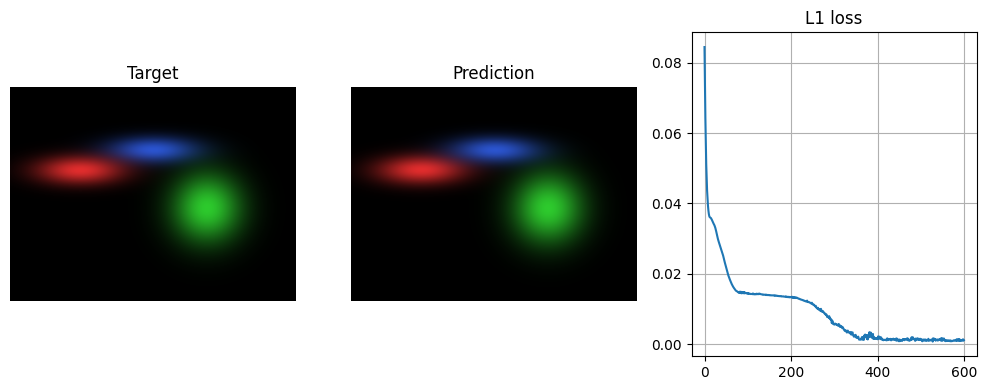

In [8]:
# Stage 7: Save & visualize
import matplotlib.pyplot as plt
import imageio.v3 as iio

with torch.no_grad():
	I_pred_final = render_gaussians(model, H, W, f, cx, cy, device)

I8_gt = (I_star.clamp(0,1).cpu().numpy() * 255).astype('uint8')
I8_pd = (I_pred_final.clamp(0,1).cpu().numpy() * 255).astype('uint8')

# Lưu ảnh (nếu imageio đã cài)
iio.imwrite('target.png', I8_gt)
iio.imwrite('prediction.png', I8_pd)

# Hiển thị trong notebook
plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.title("Target"); plt.imshow(I_star.cpu()); plt.axis('off')
plt.subplot(1,3,2); plt.title("Prediction"); plt.imshow(I_pred_final.cpu()); plt.axis('off')
plt.subplot(1,3,3); plt.title("L1 loss"); plt.plot(loss_hist); plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# Option: Densification toy (chèn thử sau mỗi 100 bước trong loop)
# Ý tưởng: đo độ lớn grad của model.mu, nếu lớn và scale nhỏ -> clone; nếu lớn và scale lớn -> split.
# Lưu ý: đây chỉ là demo tối giản (không tối ưu hiệu năng/ổn định).

def densify_toy(model, grad_mu_thresh=1e-2, split_scale_thresh=0.25):
	with torch.no_grad():
		mu, Sigma, alpha, color = model.forward_params()
		if model.mu.grad is None:
			return
		g = model.mu.grad.norm(dim=-1)  # (K,)
		mask = g > grad_mu_thresh
		if mask.sum() == 0:
			return

		# Lấy scale (đã exp)
		scale = torch.exp(model.scale_log)  # (K,3)
		area_like = scale.prod(dim=-1)     # thô: tích ba trục

		clone_idx = torch.where(mask & (area_like < split_scale_thresh))[0]
		split_idx = torch.where(mask & (area_like >= split_scale_thresh))[0]

		def append_params(p, add):
			return nn.Parameter(torch.cat([p.data, add], dim=0).to(p.device))

		# Clone: copy tham số & dịch μ theo hướng grad
		if clone_idx.numel() > 0:
			delta = 0.02 * F.normalize(model.mu.grad[clone_idx], dim=-1)
			model.mu = append_params(model.mu, model.mu.data[clone_idx] + delta)
			model.scale_log = append_params(model.scale_log, model.scale_log.data[clone_idx])
			model.q = append_params(model.q, quat_normalize(model.q.data[clone_idx]))
			model.alpha_logit = append_params(model.alpha_logit, model.alpha_logit.data[clone_idx])
			model.color_logit = append_params(model.color_logit, model.color_logit.data[clone_idx])

		# Split: tạo 2 hạt nhỏ hơn (ở đây demo tạo thêm 1 hạt, scale giảm)
		if split_idx.numel() > 0:
			reduce = math.log(1.6)
			new_scale_log = model.scale_log.data[split_idx] - reduce
			jitter = 0.01 * torch.randn_like(model.mu.data[split_idx])
			model.mu = append_params(model.mu, model.mu.data[split_idx] + jitter)
			model.scale_log = append_params(model.scale_log, new_scale_log)
			model.q = append_params(model.q, quat_normalize(model.q.data[split_idx]))
			model.alpha_logit = append_params(model.alpha_logit, model.alpha_logit.data[split_idx])
			model.color_logit = append_params(model.color_logit, model.color_logit.data[split_idx])

		# Re-register params (hack nhỏ vì ta thay tham số)
		model._parameters['mu'] = model.mu
		model._parameters['scale_log'] = model.scale_log
		model._parameters['q'] = model.q
		model._parameters['alpha_logit'] = model.alpha_logit
		model._parameters['color_logit'] = model.color_logit
